In [3]:
!pip install keras_layer_normalization
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
import tensorflow as tf
from keras.utils import np_utils
from keras.layers import Layer
import os
import keras.backend as K
import numpy as np
from keras_layer_normalization import LayerNormalization
from keras import regularizers


BATCH_NORM = True
NOISE = True
batch_size =  32
num_classes = 10
epochs = 50


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test_samples')

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

class NoiseLayer(Layer):

    def __init__(self, mean, stddev, **kwargs):
        super(NoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
        self.mean = mean

    def call(self, inputs, training=None):
        def noised():
            return inputs + K.random_normal(shape=K.shape(inputs), mean=self.mean, stddev = self.stddev)
        return K.in_train_phase(noised, inputs, training=training)

    def get_config(self):
        config = {'mean': self.mean, 'stddev': self.stddev}
        base_config = super(NoiseLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


def base_model(i):
    model = Sequential()
    model.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l1(i), padding='same',input_shape=x_train.shape[1:]))
    #model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
    model.add(LayerNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(i)))
    #model.add(Conv2D(32, (3, 3)))
    model.add(LayerNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(i)))
    model.add(LayerNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    

    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=regularizers.l1(i)))
    model.add(LayerNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes, kernel_regularizer=regularizers.l1(i)))
    model.add(Activation('softmax'))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])  
    
    #model.save_weights('./' + str(i) + '_weights.h5')
    
    return model

  
for i in [0.1]:
  K.clear_session()
  model = base_model(i)
  model.summary()
  tensorboard = TensorBoard(log_dir='./' + str(i), histogram_freq=epochs, write_graph=True, write_images=False)
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True, callbacks=[tensorboard])
  model.save_weights('./' + str(i) + '_weights.h5')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test_samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
layer_normalization_1 (Layer (None, 32, 32, 32)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
layer_normalization_2 (Layer (None, 30, 30, 32)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max

W shape :  (3, 3, 3, 32)
(3, 3, 32)
32
(3, 3)
Saving histogram of weights in: l1_alone_0.1.png
W shape :  (3, 3, 3, 32)
(3, 3, 32)
32
(3, 3)
Saving histogram of weights in: l1_alone_0.01.png
W shape :  (3, 3, 3, 32)
(3, 3, 32)
32
(3, 3)
Saving histogram of weights in: l1_alone_0.001.png
W shape :  (3, 3, 3, 32)
(3, 3, 32)
32
(3, 3)
Saving histogram of weights in: l1_alone_0.0001.png


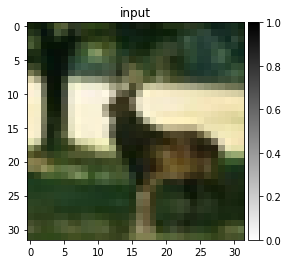

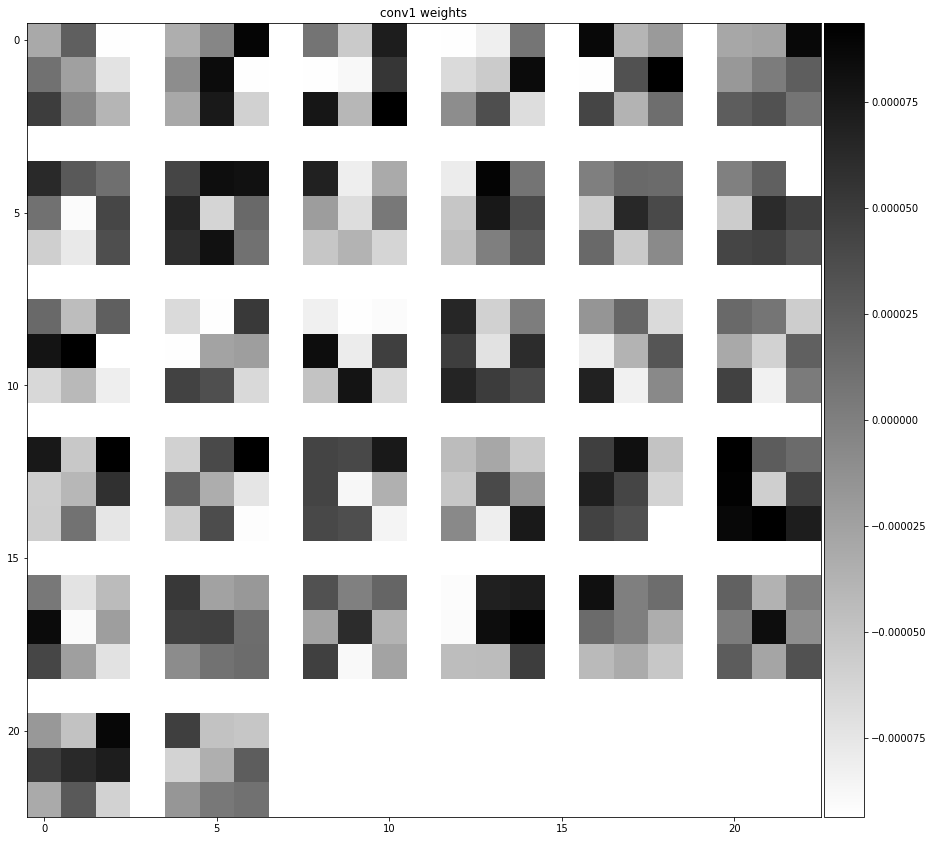

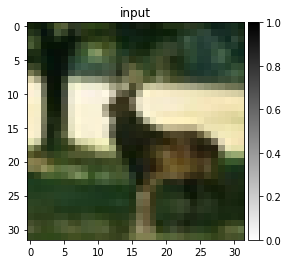

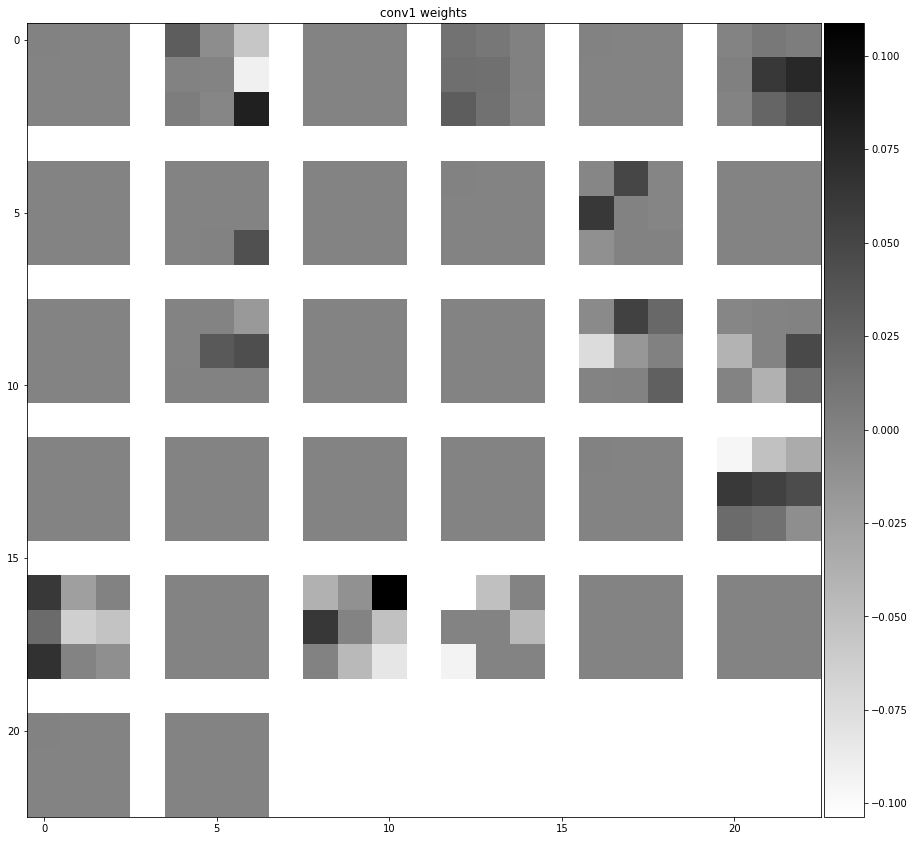

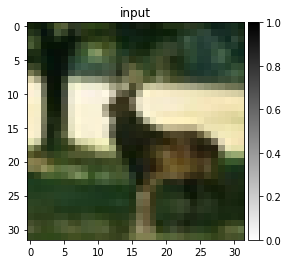

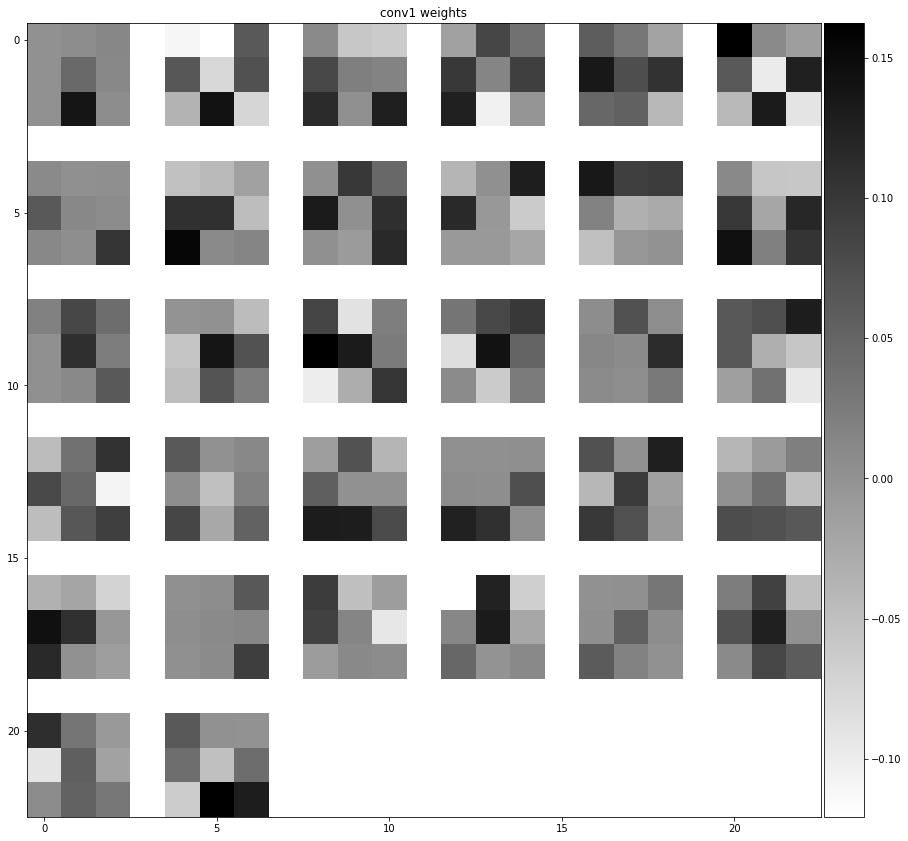

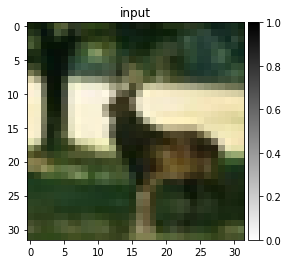

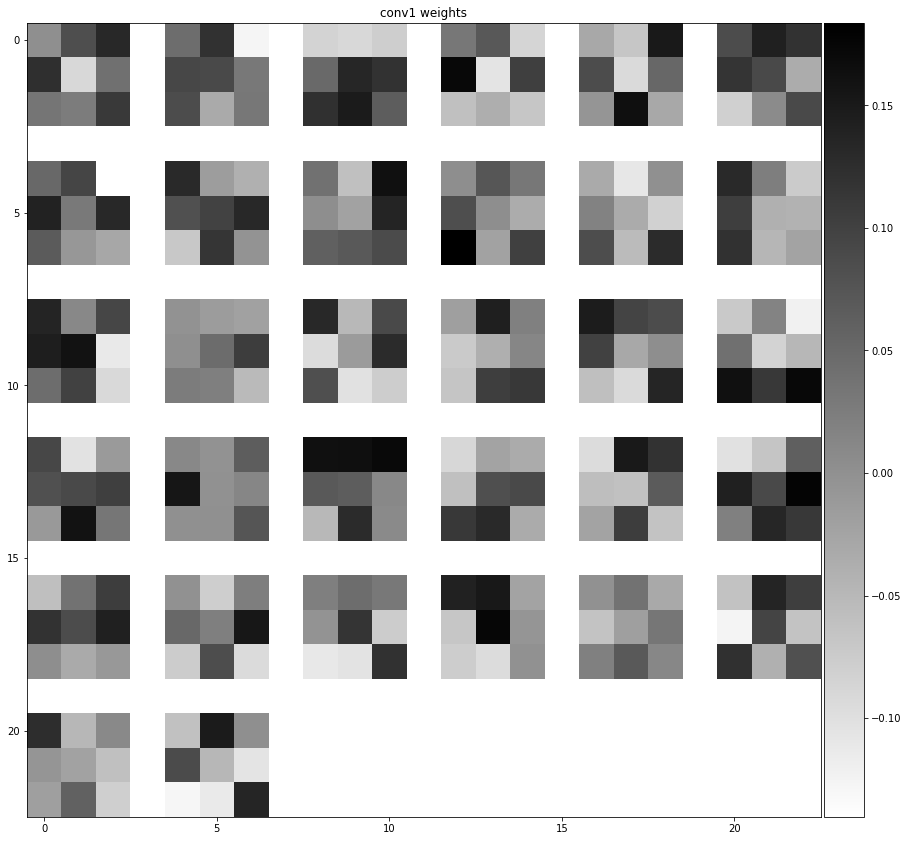

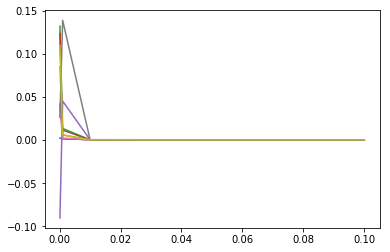

In [4]:
import pylab as pl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import theano
from keras.regularizers import l2, l1

def plot_weights(flat_weights, plot_file_name, title_name):
    fig = pl.figure()
    ax = fig.add_subplot(111)
    pl.suptitle("Weights histogram (1st Conv layer): " + title_name)
    ax.hist(flat_weights, NUM_PLOT_BINS, color='green', alpha=0.8)
    print("Saving histogram of weights in:", plot_file_name)
    fig.savefig(plot_file_name)
    pl.close(fig)
    

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    print(imgs.shape)
    nimgs = imgs.shape[-1]
    print(nimgs)
    imshape = imgs.shape[0:-1]
    print(imshape)
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic


def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    

lamdas = [0.1, 0.01, 0.001, 0.0001]
# lamdas = [0]
nb_groups = 2
NUM_PLOT_BINS = 30
weights = np.empty((9,0))
for lam in lamdas:
    regularizer = l1(lam)
    model = base_model(lam)
    weight_path = './' + str(lam) + '_weights.h5'
    model.load_weights(weight_path)

    i = 4600

    # Visualize the first layer of convolutions on an input image
    X = x_test[i:i+1]

    pl.figure()
    pl.title('input')
    nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)

    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)
    print("W shape : ", W.shape)

    pl.figure(figsize=(15, 15))
    pl.title('conv1 weights')
    nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6), cmap=cm.binary)


    # Visualize histograms of weights
    plot_weights(W[0].reshape(-1,1), 'l1_alone_' + str(lam) + '.png', 'l1_alone_' + str(lam) )

    weights = np.hstack((weights, W[0][:,:,0].reshape(-1,1)))
pl.figure()
for i in range(len(weights)):
    pl.plot(lamdas, weights[i,:])
pl.show()